In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [2]:
tf.random.set_seed(0)

# Check the heuristics to select nosie variance

In [3]:
from src.ksd.kernel import median_heuristic, l2norm
from src.ksd.models import create_mixture_gaussian

In [4]:
dim = 5
n = 500

# Oracle choice of variance

In [5]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

2022-03-06 21:55:26.770613: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-06 21:55:27.322911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


In [6]:
var = 5.
convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

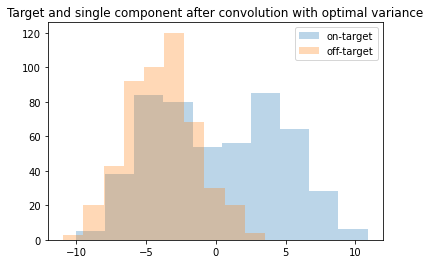

In [7]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component after convolution with optimal variance")

# Med heuristic

In [8]:
med_ls = []
delta_ls = np.linspace(1., 10, 100)
for delta in tqdm(delta_ls):
    target = create_mixture_gaussian(dim=dim, delta=delta)
    samples = target.sample(500)
    l2norm_mat = l2norm(samples, tf.identity(samples))
    med_ls.append(median_heuristic(l2norm_mat) / dim)
    

  0%|          | 0/100 [00:00<?, ?it/s]

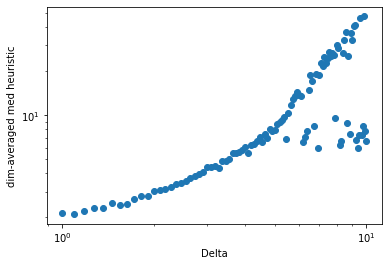

In [9]:
plt.scatter(delta_ls, med_ls)
plt.xscale("log")
plt.yscale("log")
_ = plt.xlabel("Delta")
_ = plt.ylabel("dim-averaged med heuristic")

In [94]:
delta = delta_ls[33]
var = med_ls[33].numpy()

In [95]:
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

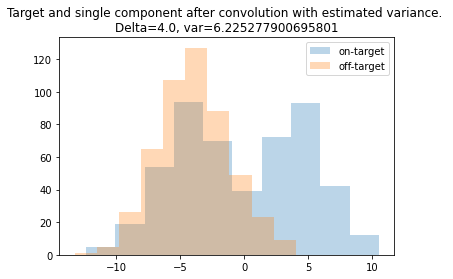

In [96]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title(f"Target and single component after convolution with estimated variance. \nDelta={delta}, var={var}")

In [97]:
# analyze robustness 
med_ls = []
nrep = 500
for _ in trange(nrep):
    target = create_mixture_gaussian(dim=dim, delta=delta)
    samples = target.sample(500)
    l2norm_mat = l2norm(samples, tf.identity(samples))
    med_val = median_heuristic(l2norm_mat).numpy() / dim
    med_ls.append(med_val)


  0%|          | 0/500 [00:00<?, ?it/s]

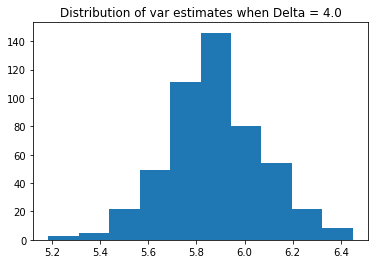

In [101]:
_ = plt.hist(med_ls)
_ = plt.title(f"Distribution of var estimates when Delta = {delta}")

# Pairwise difference as noise distribution

In [6]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)
    
samples_on = target.sample(500)
samples_off = target_off.sample(500)

2021-12-02 09:18:47.812445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 09:18:48.381654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


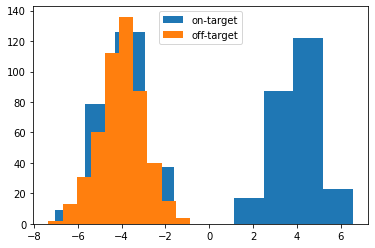

In [7]:
_ = plt.hist(samples_on.numpy()[:, 0], label="on-target")
_ = plt.hist(samples_off.numpy()[:, 0], label="off-target")
plt.legend()

In [8]:
tf.random.set_seed(0)

In [18]:
pair_diff = tf.expand_dims(samples_on, axis=0) - tf.expand_dims(samples_on, axis=1) # n x n x dim
noise_samples = tf.reshape(pair_diff, shape=(-1, dim))

In [46]:
rm_ind = [i*(n+1) for i in range(n)]
ind = [i for i in range(noise_samples.shape[0]) if i not in rm_ind]

In [50]:
noise_samples = tf.gather(noise_samples, ind)

In [19]:
noise_dist = tfp.distributions.Empirical(noise_samples, event_ndims=1)

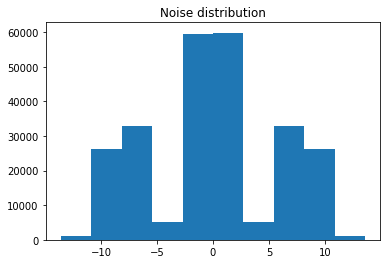

In [49]:
_ = plt.hist(noise_samples.numpy()[:, 0])
_ = plt.title("Noise distribution")

$$
\prod_{i=1}^{\min(2, d)} \left[ \frac{1}{a_i} (e^{a_i \min(1, u_i)} - 1) \right]
\prod_{i > 2} \left[ \frac{1}{a_i} (e^{a_i} - 1) \right]
$$

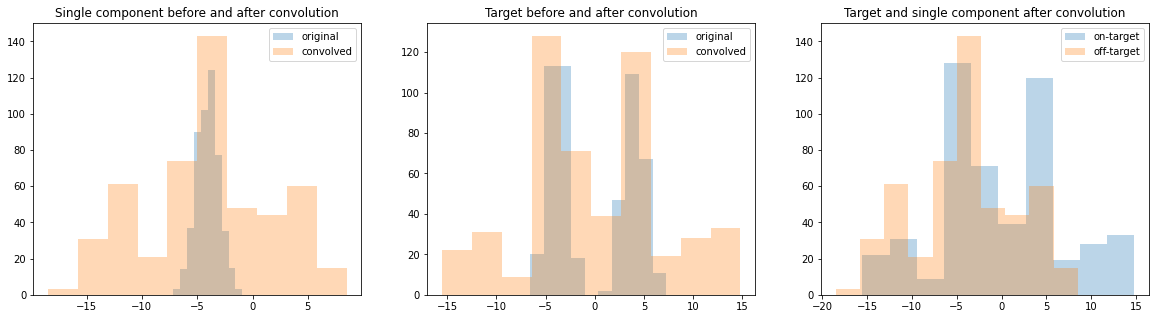

In [53]:
xx = noise_dist.sample(500)
samples_off_convolved = samples_off + xx

plt.figure(figsize=(20, 5))
plt.subplot(131)
_ = plt.hist(samples_off.numpy()[:, 0], label="original", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="convolved", alpha=0.3)
_ = plt.legend()
_ = plt.title("Single component before and after convolution")

plt.subplot(132)
samples_on_convolved = samples_on + xx
_ = plt.hist(samples_on.numpy()[:, 0], label="original", alpha=0.3)
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="convolved", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target before and after convolution")

plt.subplot(133)
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component after convolution")


# Optimization

In [28]:
from src.ksd.ksd import ConvolvedKSD

In [29]:
tf.random.set_seed(0)

In [30]:
dim = 5
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]
target_off = tfd.MultivariateNormalDiag(one_component_mean)
    
ntrain = 400

samples_on = target.sample(ntrain)
samples_off = target_off.sample(ntrain)

In [31]:
num_est = 10000
convolution = tfd.MultivariateNormalDiag(0., tf.ones(dim))
conv_samples_full = convolution.sample(num_est) # for p

conv_samples_full = conv_samples_full[:, :1] # 1D Gaussian noise

conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=ntrain)
conv_samples = tf.gather(conv_samples_full, conv_ind, axis=0) # for q

In [32]:
imq = IMQ(med_heuristic=True)

In [33]:
ksd = ConvolvedKSD(target=target, kernel=imq)

In [13]:
# log_sigma = tf.Variable([0.])
# u_vec = tf.eye(dim)[:, 0]

# param = tf.Variable(tf.concat([log_sigma, u_vec], axis=0))

# with off-target samples
# loss_fn = lambda: -ksd.eval(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)
# loss_fn = lambda: -ksd.eval_mat(param[0], samples_off, tf.identity(samples_off), conv_samples_full, conv_samples, u=u_vec)

# def loss_fn():
#     param[1:].assign(param[1:] / tf.math.sqrt(tf.reduce_sum(param[1:]**2)))
#     res = -ksd.eval_mat(param[0], samples_off, tf.identity(samples_off), conv_samples_full, conv_samples, u=param[1:])
#     var = ksd.h1_var(log_noise_std=param[0], 
#                      X=samples_off, 
#                      Y=tf.identity(samples_off), 
#                      conv_samples_full=conv_samples_full, 
#                      conv_samples=conv_samples, 
#                      u=param[1:])
#     res /= tf.math.sqrt(var) + 1e-8
#     return res

## both var and dir
log_sigma = tf.Variable([0.]) # tf.Variable([tf.math.log(delta*2)])
u_vec = tf.eye(dim)[:, 0]
param = tf.Variable(tf.concat([log_sigma, u_vec], axis=0))

def loss_fn():
    res = ksd.h1_var(
        return_scaled_ksd=True,
        log_noise_std=param[0],
        X=samples_off,
        Y=tf.identity(samples_off),
        conv_samples_full=conv_samples_full,
        conv_samples=conv_samples,
        u=param[1:])
    return -res

## only optimize for log std
# param = tf.Variable(tf.math.log(delta*2))
# u_vec = tf.eye(dim)[:, 0]
# def loss_fn():
#     res = ksd.h1_var(
#         return_scaled_ksd=True,
#         log_noise_std=param,
#         X=samples_off,
#         Y=tf.identity(samples_off),
#         conv_samples_full=conv_samples_full,
#         conv_samples=conv_samples,
#         u=u_vec)
#     return -res

In [175]:
num_steps = 200
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)

losses = tfp.math.minimize(loss_fn,
                           num_steps=num_steps,
                           optimizer=optimizer,
                           trace_fn=lambda x: x)

In [176]:
## noise var and direction
print("best var", tf.exp(param[0]).numpy()**2)
print("|| best dir - e_1 ||^2 =", tf.reduce_sum((param[1:] - tf.eye(dim)[:, 0])**2).numpy())
print("|| best dir ||^2 =", tf.reduce_sum(param[1:]**2).numpy())
print("dir vec:", param[1:])

## noise var only
# print("best var", tf.exp(param).numpy()**2)

best var 0.2550874271206318
|| best dir - e_1 ||^2 = 1.3959733
|| best dir ||^2 = 0.53685546
dir vec: tf.Tensor([ 0.07044099 -0.36425057  0.62694687  0.06559719 -0.04300747], shape=(5,), dtype=float32)


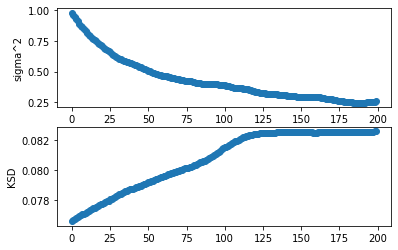

In [177]:
plt.subplot(2, 1, 1)
# plt.scatter(range(num_steps), tf.math.exp(losses.parameters[0].numpy())**2) # noise var only
plt.scatter(range(num_steps), tf.math.exp(losses.parameters[0].numpy()[:, 0])**2)
plt.ylabel("sigma^2")
plt.subplot(2, 1, 2)
plt.scatter(range(num_steps), -losses.loss.numpy())
plt.ylabel("KSD")
plt.show()

In [28]:
xx = tf.Variable([3.])
# def ff(xx):
#     xx = (xx)**2 / 4
#     return xx

# with tf.GradientTape() as tape:
#     # Forward pass.
#     loss_value = ff(xx)

# # Get gradients of loss wrt the weights.
# gradients = tape.gradient(loss_value, xx)
# gradients

def ff():
    return (xx)**2 / 4

num_steps = 200
optimizer = tf.optimizers.Adam(learning_rate=1e-1)

losses = tfp.math.minimize(ff,
                           num_steps=num_steps,
                           optimizer=optimizer,
                           trace_fn=lambda x: x)

In [194]:
## both var and dir
log_sigma = tf.Variable([0.]) # tf.Variable([tf.math.log(delta*2)])
u_vec = tf.eye(dim)[:, 0]
param = tf.Variable([tf.concat([log_sigma, u_vec], axis=0)])

def loss_fn(param):
    res = ksd.h1_var(
        return_scaled_ksd=True,
        log_noise_std=param[0, 0],
        X=samples_off,
        Y=tf.identity(samples_off),
        conv_samples_full=conv_samples_full,
        conv_samples=conv_samples,
        u=param[:1, 1:])
    return -res

## only var
# param = tf.Variable([0.])
# u_vec = tf.eye(dim)[:1, :]
# def loss_fn(param):
#     res = ksd.h1_var(
#         return_scaled_ksd=True,
#         log_noise_std=param,
#         X=samples_off,
#         Y=tf.identity(samples_off),
#         conv_samples_full=conv_samples_full,
#         conv_samples=conv_samples,
#         u=u_vec)
#     return -res

In [195]:
# Instantiate an optimizer.
num_steps = 200
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

# Iterate over the batches of a dataset.
losses_ls = []
param_ls = []
for _ in trange(num_steps):
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        loss_value = loss_fn(param)

    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss_value, param)
    
    losses_ls.append(loss_value)
    param_ls.append(tf.constant(param))

    # Update the weights of the model.
    optimizer.apply_gradients(zip([gradients], [param]))

  0%|          | 0/200 [00:00<?, ?it/s]

best var [5.0634861e-01 3.2673337e+00 3.6294416e-02 5.6396408e+00 1.8427220e+02
 1.7737098e-01]
|| best dir - e_1 ||^2 = 11.214207
|| best dir ||^2 = 11.398181
dir vec: tf.Tensor([ 0.59198713 -1.6580458   0.8649102   2.608207   -0.8647559 ], shape=(5,), dtype=float32)


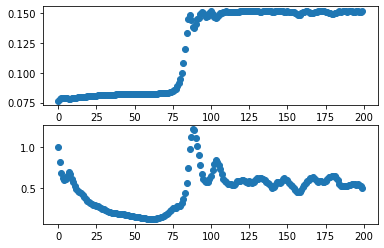

In [197]:
## noise var and direction
print("best var", tf.exp(param[0]).numpy()**2)
print("|| best dir - e_1 ||^2 =", tf.reduce_sum((param[0, 1:] - tf.eye(dim)[:, 0])**2).numpy())
print("|| best dir ||^2 =", tf.reduce_sum(param[0, 1:]**2).numpy())
print("dir vec:", param[0, 1:])

## only var
# print("best var", tf.exp(param).numpy()**2)

## both var and dir
plt.subplot(2, 1, 1)
plt.scatter(range(num_steps), [-x for x in losses_ls])
plt.subplot(2, 1, 2)
plt.scatter(range(num_steps), [tf.exp(x[0, 0])**2 for x in param_ls])

## only var
# plt.subplot(2, 1, 1)
# plt.scatter(range(num_steps), [-x for x in losses_ls])
# plt.subplot(2, 1, 2)
# plt.scatter(range(num_steps), [tf.exp(x)**2 for x in param_ls])

In [183]:
num_steps = 200
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

## both var and dir
# log_sigma = tf.Variable([0.]) # tf.Variable([tf.math.log(delta*2)])
# u_vec = tf.eye(dim)[:, 0]
# param = tf.Variable([tf.concat([log_sigma, u_vec], axis=0)])

# ksd.optim(
#     nsteps=num_steps,
#     optimizer=optimizer,
#     param=param,
#     X=samples_off,
#     Y=tf.identity(samples_off),
#     conv_samples_full=conv_samples_full,
#     conv_samples=conv_samples,
#     verbose=True
# )

## only var
param = tf.Variable([3.])
u_vec = tf.eye(dim)[:1, :]

ksd.optim_var(
    nsteps=num_steps,
    optimizer=optimizer,
    param=param,
    u_vec=u_vec,
    X=samples_off,
    Y=tf.identity(samples_off),
    conv_samples_full=conv_samples_full,
    conv_samples=conv_samples,
    verbose=True
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.52it/s]


In [184]:
# ## do not separate length
# param2 = tf.constant(param[0, :])
# param = tf.reshape(tf.concat([[0.5*tf.math.log(tf.reduce_sum(param2**2))], param2], axis=0), (1, -1))

best var [9.706951]
dir vec: tf.Tensor([[1. 0. 0. 0. 0.]], shape=(1, 5), dtype=float32)


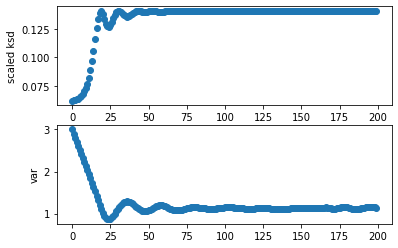

In [185]:
param = ksd.params[-1]

## noise var and direction
# print("best var", tf.exp(param[0, 0]).numpy()**2)
# print("|| best dir - e_1 ||^2 =", tf.reduce_sum((param[:1, 1:] - tf.eye(dim)[:1, :])**2).numpy())
# print("|| best dir ||^2 =", tf.reduce_sum(param[:1, 1:]**2).numpy())
# print("dir vec:", param[0, 1:])

## only var
print("best var", tf.exp(param).numpy()**2)
print("dir vec:", u_vec)

## both var and dir
# plt.subplot(2, 1, 1)
# plt.scatter(range(num_steps), [-x for x in ksd.losses])
# _ = plt.ylabel("scaled ksd")
# plt.subplot(2, 1, 2)
# plt.scatter(range(num_steps), [tf.exp(x[0, 0])**2 for x in ksd.params])
# _ = plt.ylabel("var")
# # plt.scatter(range(num_steps), [tf.reduce_sum(x**2) for x in ksd.params])

## only var
plt.subplot(2, 1, 1)
plt.scatter(range(num_steps), [-x for x in ksd.losses])
_ = plt.ylabel("scaled ksd")
plt.subplot(2, 1, 2)
plt.scatter(range(num_steps), [x for x in ksd.params])
_ = plt.ylabel("var")

In [174]:
std_list = [tf.math.pow(2., x) for x in tf.experimental.numpy.arange(-50., 50., 1.0).numpy() / 5]
losses = []

# u_vec = param[:1, 1:]
u_vec = tf.eye(dim)[:1, :]
loss_fn = lambda x: -ksd.eval_mat(x, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples, u=u_vec)

for std in std_list:
    log_noise_std = tf.math.log(std)
    res = ksd.h1_var(return_scaled_ksd=True,
                    log_noise_std=log_noise_std,
                    X=samples_off,
                    Y=tf.identity(samples_off),
                    conv_samples_full=conv_samples_full,
                    conv_samples=conv_samples,
                    u=u_vec)

    losses.append(res)

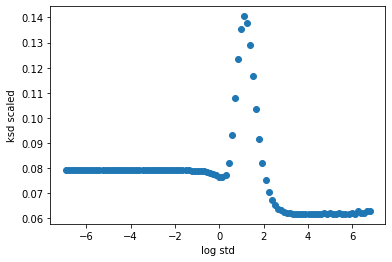

In [175]:
_ = plt.scatter([ tf.math.log(x).numpy() for x in std_list], losses)
_ = plt.xlabel("log std")
_ = plt.ylabel("ksd scaled")

In [72]:
# get p-value for this set of params
from src.ksd.bootstrap import Bootstrap
n = ntrain*2
num_boot = 1000

samples_off_test = target_off.sample(n-ntrain)
bootstrap = Bootstrap(ksd, n-ntrain)
multinom_samples = bootstrap.multinom.sample((1, num_boot))

In [198]:
## var and dir vec
# assert param.shape == (1, dim+1)

# multinom_one_sample = multinom_samples[0, :]
# conv_samples_test = conv_samples
# _, p_val = bootstrap.test_once(
#     alpha=0.05, 
#     num_boot=num_boot, 
#     X=samples_off_test, 
#     multinom_samples=multinom_one_sample, 
#     conv_samples_full=conv_samples_full,
#     conv_samples=conv_samples_test,
#     log_noise_std=param[0, 0],
#     u=param[:1, 1:]
# )
# p_val

## only var
multinom_one_sample = multinom_samples[0, :]
conv_samples_test = conv_samples
_, p_val = bootstrap.test_once(
    alpha=0.05, 
    num_boot=num_boot, 
    X=samples_off_test, 
    multinom_samples=multinom_one_sample, 
    conv_samples_full=conv_samples_full,
    conv_samples=conv_samples_test,
    log_noise_std=param,
    u=u_vec
)
p_val

0.3856143856143856

<AxesSubplot:xlabel='x1', ylabel='Proportion'>

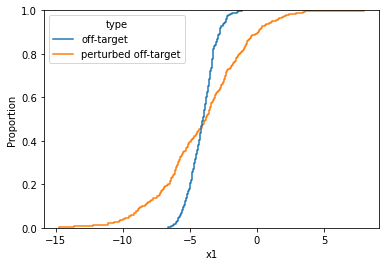

In [189]:
off_sample_init = samples_off_test
## var and dir vec
# convolution_sample_off = conv_samples_test @ param[:1, 1:] * tf.exp(param[0, 0])
## only var
convolution_sample_off = conv_samples_test @ u_vec * tf.exp(param)

off_sample_pert = (samples_off_test + convolution_sample_off).numpy()
samples_df_off_target = pd.DataFrame({
    "x1": off_sample_init[:, 0],
    "x2": off_sample_init[:, 1],
    "type": "off-target"})
samples_df_off_perturbed = pd.DataFrame({
    "x1": off_sample_pert[:, 0],
    "x2": off_sample_pert[:, 1],
    "type": "perturbed off-target"})
samples_df_off = pd.concat([samples_df_off_target, samples_df_off_perturbed], ignore_index=True)

sns.ecdfplot(data=samples_df_off, x="x1", hue="type")
# sns.scatterplot(data=samples_df_off, x="x1", y="x2", hue="type", alpha=0.5)
# plt.axis(xmin=-xlim, xmax=xlim, ymin=-ylim, ymax=ylim)

In [123]:
vv = tf.reshape(param[1:], (1, -1))
tf.transpose(vv) @ vv

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 0.00683705,  0.00635289, -0.07172872,  0.00907793, -0.03798293],
       [ 0.00635289,  0.00590301, -0.06664933,  0.00843509, -0.03529321],
       [-0.07172872, -0.06664933,  0.75251937, -0.09523825,  0.398486  ],
       [ 0.00907793,  0.00843509, -0.09523825,  0.01205328, -0.05043207],
       [-0.03798293, -0.03529321,  0.398486  , -0.05043207,  0.21101263]],
      dtype=float32)>

In [48]:
# with on-target samples
loss_fn = lambda: -ksd.eval(log_sigma, samples_on, tf.identity(samples_on), conv_samples_full, conv_samples)

losses = tfp.math.minimize(loss_fn,
                           num_steps=100,
                           optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                           convergence_criterion=tfp.optimizer.convergence_criteria.LossNotDecreasing(rtol=0.1))

print(-losses)
print("best var", tf.exp(log_sigma).numpy()**2)

tf.Tensor(
[0.01143235 0.01143237 0.01143243 0.01143234 0.01143243 0.01143239
 0.01143242 0.0114324  0.01143235 0.01143238 0.01143243 0.01143241
 0.0114324  0.01143242 0.01143241 0.01143241 0.01143242 0.0114324
 0.01143241 0.01143243 0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.0114324
 0.0114324  0.0114324  0.0114324  0.0114324  0.0114324  0.01143

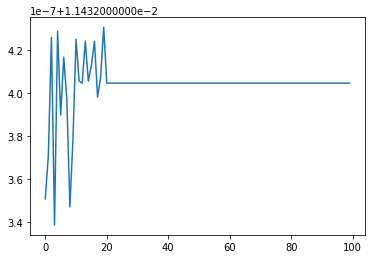

In [50]:
plt.plot(range(len(losses)), -losses)

In [29]:
# optimizing the difference
# def loss_fn():
#     res = -(
#         ksd.eval(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)
#         - ksd.eval(log_sigma, samples_on, tf.identity(samples_on), conv_samples_full, conv_samples)
#     )
#     return res

log_sigma = tf.Variable([2.])
def loss_fn():
    res = -ksd.eval(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)
    var = ksd.h1_var(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)
    res /= tf.sqrt(var)
    return res

losses = tfp.math.minimize(loss_fn,
                           num_steps=100,
                           optimizer=tf.optimizers.Adam(learning_rate=1e-2))

print(-losses)
print("best var", tf.exp(log_sigma).numpy()**2)

tf.Tensor(
[0.17060621 0.17075396 0.17089655 0.17103769 0.171165   0.17126761
 0.1713774  0.17150691 0.17164823 0.17182197 0.17205049 0.17233928
 0.17270315 0.17314422 0.17366351 0.17427959 0.17500012 0.17577772
 0.17664391 0.17757249 0.1785276  0.17951217 0.18053533 0.18160152
 0.18265782 0.1837054  0.1847289  0.18575631 0.18684478 0.18811114
 0.18967216 0.19169848 0.19432609 0.1975931  0.20141424 0.20572874
 0.21034676 0.21517612 0.22018676 0.22543463 0.23100846 0.23696145
 0.24329957 0.24998668 0.2569755  0.26418447 0.27152136 0.2789279
 0.28635013 0.29373607 0.30107206 0.3083394  0.3154962  0.3224677
 0.3291056  0.33531615 0.3410148  0.34626758 0.3511859  0.3560181
 0.36093435 0.3660988  0.37164786 0.3775733  0.3838801  0.39057076
 0.39763615 0.4049919  0.4125747  0.4202866  0.4279453  0.43533212
 0.44226256 0.44844446 0.4537573  0.45806998 0.4613843  0.4637234
 0.46516138 0.46582827 0.4658443  0.46544185 0.46474236 0.4638512
 0.4629475  0.46210226 0.46139497 0.46080083 0.4604236  

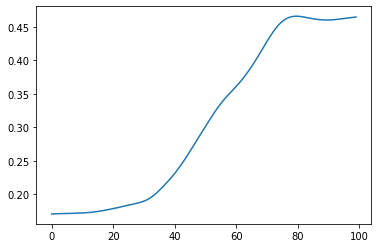

In [30]:
plt.plot(range(len(losses)), -losses)

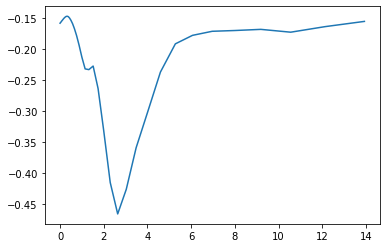

In [26]:
# def loss_fn(log_sigma):
#     res = -ksd.eval(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)
#     var = ksd.h1_var(log_sigma, samples_off, tf.identity(samples_off), conv_samples_full, conv_samples)
#     res /= tf.sqrt(var)
#     return res

# sigma_list = [tf.math.pow(2., x) for x in tf.experimental.numpy.arange(-50., 50., 1.0).numpy() / 5]
# res_list = []
# for s in sigma_list:
#     log_s = tf.math.log(s)
#     res_list.append(loss_fn(log_s).numpy())
    
plt.plot(sigma_list[:70], res_list[:70])
# plt.xscale("log")

## Convolved KSD as a function of log std

In [5]:
from src.ksd.ksd import ConvolvedKSD
tf.random.set_seed(0)

In [13]:
delta = 4.
n = 500
num_est = 10000

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

convolution = tfd.MultivariateNormalDiag(0., tf.ones(dim))

kernel = IMQ(med_heuristic=True)

ksd = ConvolvedKSD(target=target, kernel=kernel, conv_kernel=None)

std_list = [tf.math.pow(2., x) for x in tf.experimental.numpy.arange(-50., 50., 1.0).numpy() / 5]

In [14]:
# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)

In [15]:
ksd_df = pd.DataFrame(columns=["n", "ksd", "ksd_scaled", "std", "seed", "type"])

for std in tqdm(std_list):
    for seed in range(10):
            # convolution sample
            conv_sample_full = convolution.sample(num_est) # for p

            conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
            conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

#             # off-target sample
#             off_sample = proposal_off.sample(n)

            log_noise_std = tf.math.log(std)

            ksd_val_off = ksd.eval(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            var_off = ksd.h1_var(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_val_off_scaled = ksd_val_off / np.sqrt(var_off)
            #             ksd_val_off = ksd.eval_mat(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample, u=u_vec).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_off, ksd_val_off_scaled, np.exp(log_noise_std), seed, "off-target"]

#             # on-target sample
#             on_sample = proposal_on.sample(n)

            log_noise_std_on = log_noise_std
            ksd_val_on = ksd.eval(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            var_on = ksd.h1_var(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_val_on_scaled = ksd_val_on / np.sqrt(var_on)
#             ksd_val_on = ksd.eval_mat(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample, u=u_vec).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_on, ksd_val_on_scaled, np.exp(log_noise_std_on), seed, "target"]


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'delta = 2.0, scaled KSD')

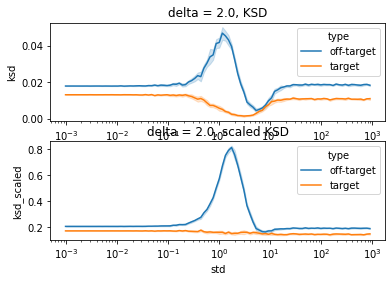

In [33]:
fig, axes = plt.subplots(2, 1)

sns.lineplot(ax=axes[0], data=ksd_df, x="std", y="ksd", hue="type")
axes[0].set_xscale("log")
axes[0].set_title(f"delta = {delta}, KSD")

sns.lineplot(ax=axes[1], data=ksd_df, x="std", y="ksd_scaled", hue="type")
axes[1].set_xscale("log")
axes[1].set_title(f"delta = {delta}, scaled KSD")

Text(0.5, 1.0, 'delta = 4.0, scaled KSD')

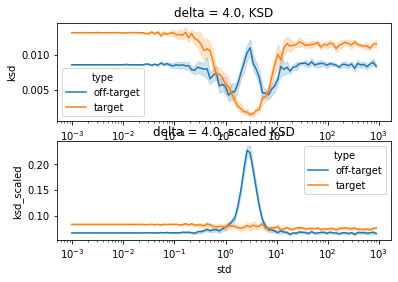

In [16]:
fig, axes = plt.subplots(2, 1)

sns.lineplot(ax=axes[0], data=ksd_df, x="std", y="ksd", hue="type")
axes[0].set_xscale("log")
axes[0].set_title(f"delta = {delta}, KSD")

sns.lineplot(ax=axes[1], data=ksd_df, x="std", y="ksd_scaled", hue="type")
axes[1].set_xscale("log")
axes[1].set_title(f"delta = {delta}, scaled KSD")

Text(0.5, 1.0, 'delta = 6.0, scaled KSD')

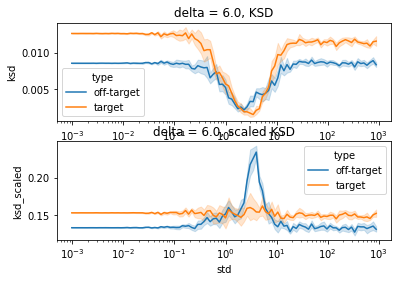

In [26]:
fig, axes = plt.subplots(2, 1)

sns.lineplot(ax=axes[0], data=ksd_df, x="std", y="ksd", hue="type")
axes[0].set_xscale("log")
axes[0].set_title(f"delta = {delta}, KSD")

sns.lineplot(ax=axes[1], data=ksd_df, x="std", y="ksd_scaled", hue="type")
axes[1].set_xscale("log")
axes[1].set_title(f"delta = {delta}, scaled KSD")

## Std estimate

In [26]:
noptim_steps = 100

optimizer = tf.optimizers.Adam(learning_rate=0.1)

In [27]:
std_est_list = []
for seed in trange(100):
    # convolution sample
    conv_sample_full = convolution.sample(num_est) # for p

    conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
    conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

    # off-target sample
    off_sample = proposal_off.sample(n)

    log_noise_std = tf.Variable(1.)

    ksd.optim(noptim_steps, log_noise_std, off_sample, tf.identity(off_sample), conv_sample_full, conv_sample, optimizer)
    
    std_est_list.append(tf.math.exp(log_noise_std).numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

2021-12-09 09:24:00.305733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [48]:
# std_est_list_orig = std_est_list
var_est_list = [x**2 for x in std_est_list if x <= 100]

In [49]:
np.mean(var_est_list) - 1.96*np.std(var_est_list)/np.sqrt(n), np.mean(var_est_list) + 1.96*np.std(var_est_list)/np.sqrt(n)

(9.135756177888009, 9.708941349638732)

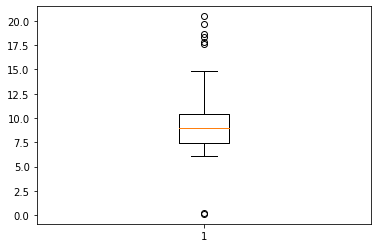

In [54]:
_ = plt.boxplot(var_est_list)

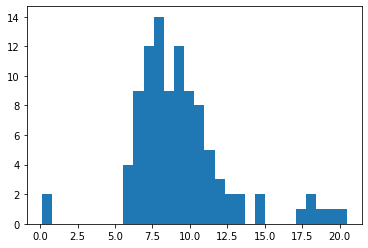

In [53]:
_ = plt.hist(var_est_list, bins=30)

In [61]:
res = pd.read_csv("res/compare_samplers/4.0_optim.csv")

In [79]:
vv = res.loc[(res.type == "off-target") & (res.n == 500)]

In [87]:
vv.ksd.to_numpy() - res.loc[(res.type == "target") & (res.n == 500), "ksd"].to_numpy()

array([-0.00137382, -0.02142556, -0.01472314,  0.00107817, -0.00452128,
       -0.00137245, -0.00258348,  0.00278895, -0.0110436 , -0.00738295])

In [81]:
[x for x in vv.var_est]

[4.894699866680696,
 2.0358307685265257e-06,
 12.384079565996217,
 0.0001498157094,
 6.782292919447684,
 1.3811616051831856e-05,
 8.004496920914846,
 255278.27177478463,
 7.0937639830845,
 1038485.8909621836]

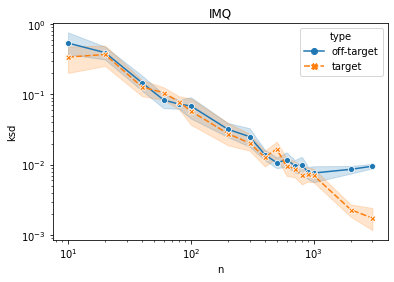

In [91]:
sns.lineplot(data=res, x="n", y="ksd", hue="type", style="type", markers=True)
plt.title("IMQ")
plt.xscale("log")
plt.yscale("log")

# Check whether the prob increases by scaling

In [119]:
delta = 4.
left_component_mean = - delta * tf.eye(1)[:, 0]
threshold = -1.

def prob_scaling(sigma_list):
    n = 10000
    
    prob_list = []
    x1_list = []
    
    for sigma in tqdm(sigma_list):
        left_component = tfd.MultivariateNormalDiag(sigma * left_component_mean, scale_identity_multiplier=sigma)
        sample = left_component.sample((n))
        prob = (sample[:, 0] > threshold).numpy().mean()
        prob_list.append(prob)
        x1_list += [[x[0].numpy(), sigma] for x in sample]
    
    prob_df = pd.DataFrame({"sigma": sigma_list, "prob": prob_list})
    x1_df = pd.DataFrame(x1_list, columns=["x1", "sigma"])
    return prob_df, x1_df

In [120]:
sigma_list = [tf.math.pow(2., x).numpy() for x in tf.experimental.numpy.arange(-10., 10., 1.0).numpy()]
prob_df, x1_df = prob_scaling(sigma_list)

  0%|          | 0/20 [00:00<?, ?it/s]

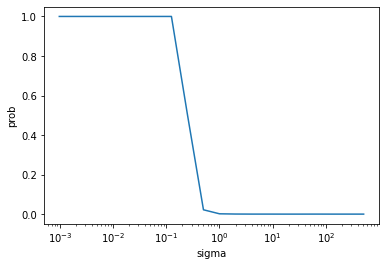

In [121]:
sns.lineplot(data=prob_df, x="sigma", y="prob", markers=True)
plt.xscale("log")

(0.0, 0.1)

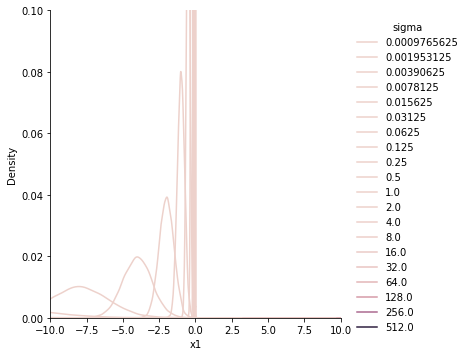

In [123]:
sns.displot(data=x1_df, x="x1", hue="sigma", kind="kde")
plt.xlim((-10, 10))
plt.ylim((0., 0.1))